<a href="https://colab.research.google.com/github/ColeHenson/Data-Science24-25/blob/main/ColeHensU7proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crime and Immigration

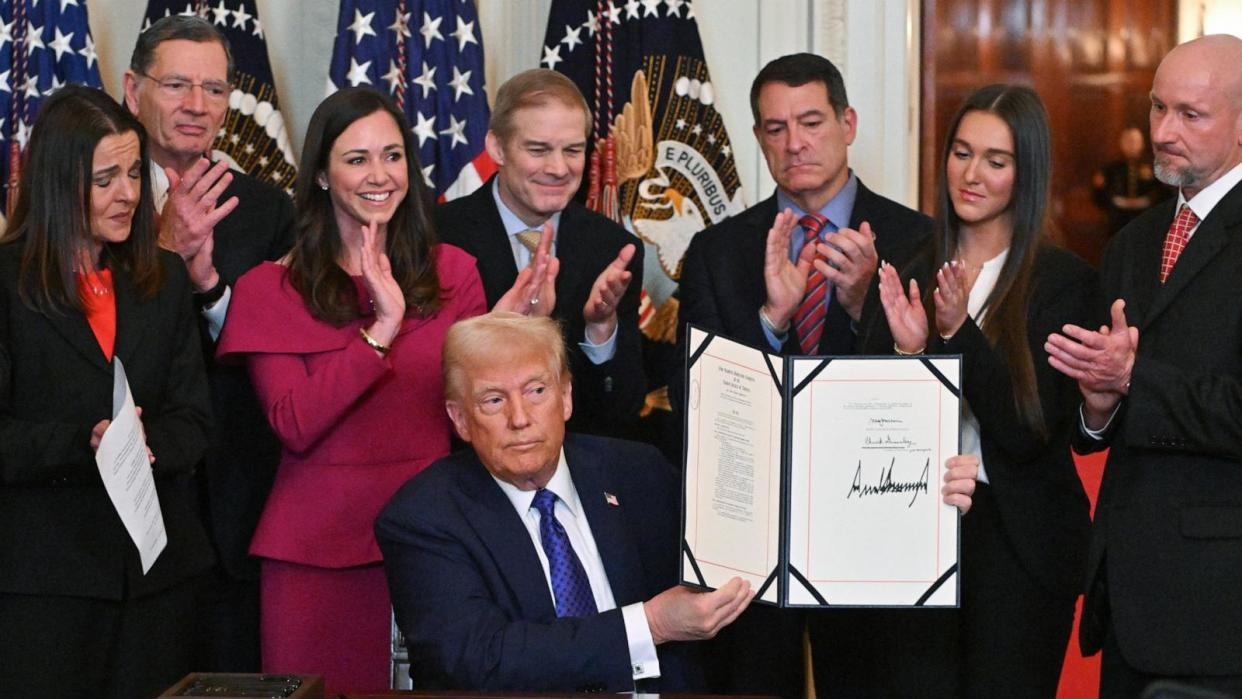

Donald Trump after signing the Laken Riley act, a law that requires the Department of Homeland Security to detain illegal immigrants convicted of theft related crimes.

# Data

An axios/ispos poll from January 19th 2025 found that roughly 2/3 Americans support the deportation of immigrants that entered the country illegally (Jackson). This trend in sentiment around immigration was further reflected in the 2024 elections in which the republican party won both the presidecy and the legislature on a platform that heavily emphasised the increased levels of illegal immigration under the biden administration. A large part of this political messaging relies of the belief that immigrants commit large numbers of violent crimes. While anecdotal evidence such as the murder of Laken Riley serve as powerful sources of messaging for anti immigrant policies, imperical evidence suggest that incarceration rates for immigrants is actually substantially lower than for native born Americans (Abramitzky).

In [73]:
#from notes
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi
!pip install preliz

import preliz as pz
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-biftoral
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-biftoral
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [74]:
#cf is crime-foreign
#crime is rate of violent crime per 100,000 people
#foreign is the size of the foreign born population per 100,000
cf = pd.read_csv("https://raw.githubusercontent.com/ColeHenson/Data-Science24-25/refs/heads/main/crime%20rate%20data.csv")
cf

,State,Year,population,crime,foreign
0,Alabama,1960,3266740,186.6,457.795845
1,Alaska,1960,226167,104.3,3637.577542
2,Arizona,1960,1302161,207.7,5400.100295
3,Arkansas,1960,1786272,107.7,417.461618
4,California,1960,15717204,239.0,8549.217787
...,...,...,...,...,...
294,Virginia,2010,8023953,214.2,11354.989240
295,Washington,2010,6742950,313.5,13143.535100
296,West Virginia,2010,1854368,301.2,1213.944589
297,Wisconsin,2010,5691659,248.9,4478.834730


#Linear

I wanted to start with a linear model just to see where I'm at before I continue on to more complicated models.

In [75]:
model_lin_1 = bmb.Model("crime ~ poly(foreign, degree= 1)", cf, family="gaussian")
idata_lin = model_lin_1.fit()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


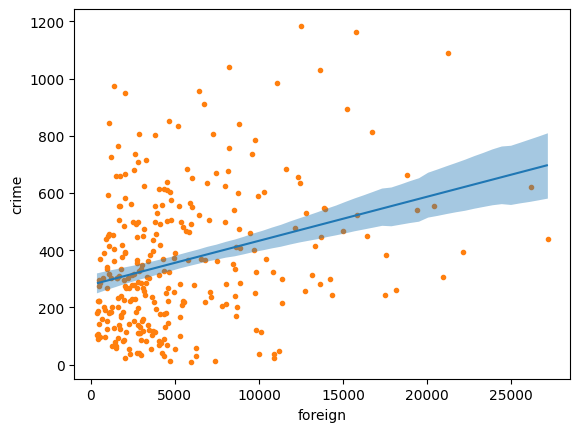

In [76]:
bmb.interpret.plot_predictions(model_lin_1, idata_lin, "foreign", pps=False)
#raw data
plt.plot(cf.foreign, cf.crime, "C1.", zorder=-3)

This graph does show a relationship between foreign born population and crime, however, the relationship is weak and the model fails to account for the wide variation in the data especially for lower values of foreign born population.

# GP

I wanted to try using a GP, however, going into this my suspicion is that the GP will not really outperform the linear model because the relationship in the data looks roughly linear. The reason I want to try a GP is that eyeballing the data isn't very conclusive.

In [77]:
#copied from notes
crime = cf["crime"].values
foreign = cf["foreign"].values[:,None]

In [78]:
#copied from notes
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [79]:
#copied from notes
with pm.Model() as model_hsgp:
    #prior for our smoothness parameter
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(foreign))

    #this is our kernal, which decides how our points relate to one another
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #this specfices that we're using an HSGP
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov)

    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X=foreign)
    #prior for the neg binomial
    α = pm.HalfNormal('α', 1)
    #likelihood
    #normal likelyhood because I think that the rates of violent crime follow a roughly normal distribution.
    y = pm.Normal("y", np.exp(f), α, observed=crime)

    idata_hsgp = pm.sample()


Output()

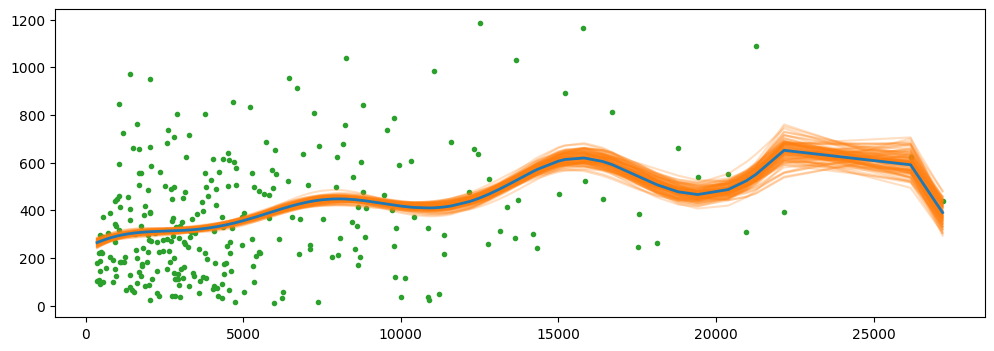

In [80]:
#set up plot
_, ax = plt.subplots(1, 1, figsize=(12, 4))
#plot raw data
ax.plot(cf["foreign"].values, cf["crime"].values, "C2.")

#grab posterior
f = az.extract(idata_hsgp, group="posterior", var_names="f")


idx = np.argsort(cf["foreign"].values)
#plot samples of the posterior
ax.plot(cf["foreign"].values[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")
#plot posterior mean
ax.plot(cf["foreign"].values[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)

The GP came up with all these wiggles in the graph. I think this model is probably worse than the linear model for a few reasons. First, it's more complicated, the relationship between crime rates and foreign born populations as we saw in the linear model is probably not as complicated as this model is making it out to be. For example, it probably is not true that crime rates suddenly rise after the foreign born population hits 20,000/100,000 and then dips after 25,000/100,000. That also gets me into my next issue: the model is probably overfitting the data. Notably this model also mostly has a positive slope, but doesn't do a good job predicting crime rates at lower levels of immigration.

#Multiple Predictors

I'm going to switch to using multiple predictors because I think that the state, and year are probably more predictive of crime rates than the foreign born populaiton is.

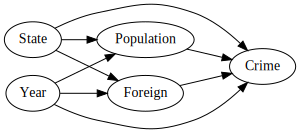

In [81]:
import graphviz
f = graphviz.Digraph('Crime dag', filename='Crime.gv')
f.attr(rankdir='LR', size='10,10')
#f is the graph f.node creates a node in the graph
f.node('Crime')
f.node('Population')
f.node('State')
f.node('Year')
f.node('Foreign')
f.edge('Population', 'Crime')
f.edge('State', 'Crime')
f.edge('Year', 'Crime')
f.edge('Foreign', 'Crime')
f.edge('State', 'Population')
f.edge('Year', 'Population')
f.edge('State', 'Foreign')
f.edge('Year','Foreign')
display(f)

State and Year impact population values as well as foreign born per 100,000 people values. All the variables cause crime. Although as I have found thus far in my project the relationship between the number of foreign born per capita and crime is tenious at best.

In [92]:
# crm_f for crime with foreign as a predictor excluding population because large population values didn't play nice last project
model_crm_f = bmb.Model("crime ~ Year + foreign + State + population", cf, family="gaussian")
idata_crm_f = model_crm_f.fit(idata_kwargs={"log_likelihood":True})

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [94]:
# crm_nf for crime without foreign as a predictor
model_crm_nf = bmb.Model("crime ~ Year + State + population", cf, family="gaussian")
idata_crm_nf = model_crm_nf.fit(idata_kwargs={"log_likelihood":True})

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

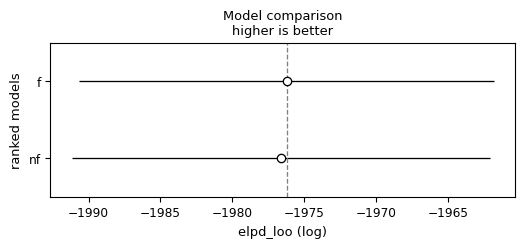

In [95]:
cmp_df = az.compare({"nf":idata_crm_nf, "f":idata_crm_f})
az.plot_compare(cmp_df)

The model comparison shows basically no difference between the models. This is further evidence to me that the proportion of the population that is foreign born has an insignficant relationship with the corresponding quantity of crime. I suspect that the earlier relationships I found using the GO were more related to differences in states rather than

### Citations

Jackson, Chris, et al. “Majority of Americans Support Deporting
     Immigrants Who Are in the U.S. Illegally.” Ipsos, 19 Jan. 2025, www.ipsos.com/en-us/majority-americans-support-deporting-immigrants-who-are-us-illegally.

Abramitzky, Ran, et al. “Law-Abiding Immigrants: The Incarceration Gap
     between Immigrants and the US-Born, 1850–2020.” National Bureau of Economic Research, 1 July 2023, www.nber.org/papers/w31440.

‌
‌